[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/stammler/simframe/HEAD?labpath=examples%2Fexample_compartmental_models.ipynb)

# Example: Compartmental Models

In this notebook we are going to investigate [compartmental models](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) for infectious diseases.  
In these models the entire population is divided into different compartments whose evolution is simulated over time.

In the first example we are going to create a simple compartmental model of a fictional disease and investigate how the compartments developed with time-dependent parameters.  
In the second example we are going to run a more complex model of the SARS-CoV-2 outbreak.

## SIRD Model

One of the simplest models is for example the SIRD model, which consists of four compartments: $S$usceptible, $I$nfectious, $R$ecovered, and $D$eceased. The four compartments are governed by the differential equations

$\frac{\mathrm{d}}{\mathrm{d}t} S = -\alpha R_1 \frac{SI}{N}$

$\frac{\mathrm{d}}{\mathrm{d}t} I = \alpha R_1 \frac{SI}{N} - (1-\beta) R_2 I - \beta R_3 I$

$\frac{\mathrm{d}}{\mathrm{d}t} R = \left(1-\beta\right) R_2 I$

$\frac{\mathrm{d}}{\mathrm{d}t} D = \beta R_3 I$

where $R_1$ is the average rate of contacts per person per time, $\alpha$ the probability of disease transmission per contact, $\beta$ the mortality, $R_2$ the average recovery time, and $R_3$ the average time until death. $N = S + I + R + D$ is the total size of the population.

There are a few key parameters to describe the system. The basic reproduction number $R_0$ is the expected number of new infections if there is one infected person with the entire population susceptible. In our model this would be.

$R_0 = \frac{\alpha R_1}{\beta R_2 + \left(1-\beta\right)R_3}$

In general, the time-dependent reproduction number is the ratio of influx into the infectious comparments to the outflux from those compartments. In our model this is

$R_t = R_0\frac{S}{N}$

To set up the model, we need to define the free parameters. We are going to assume that the population has a size of $10$ million people. On average these people have $5$ contacts per day. The transmission probability per contact of our fictitious disease it $5\,\%$. Of all infected $97\,\%$ will recover within $14$ days, while $3\,\%$ will die within $14$ days after infection. Initially we have one infected person: patient zero.

The base time unit of the model will be days.

In [1]:
N     = 10_000_000.  # Total population size
alpha = 0.05         # Transmission probability
beta  = 0.03         # Mortality
R1    = 5.           # Contacts per day
R2    = 1./14.       # Inverse recovery time
R3    = 1./14.       # Inverse time until death

I0    = 1.           # Initial infectious population

We set up the simulation frame and create a field for our state vector $\vec{Y}$ and initialize it with the initial conditions. The task of the simulation frame is to simulate the evolution of said state vector.

$\vec{Y} = \begin{pmatrix} S \\ I \\ R \\ D \end{pmatrix}$

In [2]:
Y0 = [
    N-I0,  # Susceptible
    I0,    # Infectious
    0.,    # Recovered
    0.     # Deceased
]

In [3]:
from simframe import Frame

In [4]:
sim = Frame(description="SIRD Model")

In [5]:
sim.addfield("Y", Y0, description="State Vector")

We create a group in which we store the model parameters.

In [6]:
sim.addgroup("pars", description="Model Parameters")
sim.pars.addfield("alpha", alpha, description="Transmission probability")
sim.pars.addfield("beta", beta, description="Recovery probability")
sim.pars.addfield("R1", R1, description="Contact rate")
sim.pars.addfield("R2", R2, description="Inverse recovery time")
sim.pars.addfield("R3", R3, description="Inverse time until death")
sim.pars.addfield("N", N, description="Total population size")

Additionally, we add fields for the basic reproduction number and for the reproduction number for later analysis.

In [7]:
sim.pars.addfield("Rt", 0., description="Time-dependent reproduction number")
sim.pars.addfield("R0", 0., description="Basic reproduction number")

We then define and add updaters to the reproduction numbers that calculate the numbers from the current state of the simulation frame. The compartments group, that is used in the updater of the time-dependent reproduction number, will be defined later.

In [8]:
def f_R0(sim):
    alpha, beta = sim.pars.alpha, sim.pars.beta
    R1, R2, R3 = sim.pars.R1, sim.pars.R2, sim.pars.R3
    return alpha*R1/(beta*R2+(1-beta)*R3)

In [9]:
def f_Rt(sim):
    return sim.pars.R0*sim.comp.S/sim.pars.N

In [10]:
sim.pars.R0.updater = f_R0
sim.pars.Rt.updater = f_Rt

Additionally we add an updater for the total population size, which is simply the sum of the state vector. In our model the population size will be constant, size we are not considering births.

In [11]:
def f_N(sim):
    return sim.Y.sum()

In [12]:
sim.pars.N.updater = f_N

Now we tell the simulation frame that it has to update the reproduction numbers and the population size in the parameters group.

In [13]:
sim.pars.updater = ["R0", "Rt", "N"]

For convenience we create a group for the compartments and simply copy the elements of the state vector into them in the systole of the compartment updater.

In [14]:
sim.addgroup("comp", description="Model Compartments")
sim.comp.addfield("S", sim.Y[0], description="Susceptible")
sim.comp.addfield("I", sim.Y[1], description="Infectious")
sim.comp.addfield("R", sim.Y[2], description="Recovered")
sim.comp.addfield("D", sim.Y[3], description="Deceased")

In [15]:
def f_comp_systole(sim):
    sim.comp.S[:] = sim.Y[0]
    sim.comp.I[:] = sim.Y[1]
    sim.comp.R[:] = sim.Y[2]
    sim.comp.D[:] = sim.Y[3]

In [16]:
sim.comp.updater.systole = f_comp_systole

Finally, we have to tell the main simulation frame to update the compartments and parameters groups.

In [17]:
sim.updater = ["comp", "pars"]

Now we have to write a function that returns the derivative of our state vector.

In [18]:
def f_dYdt(sim, x, Y):
    
    S, I, R, D = Y
    alpha, beta, R1, R2, R3, N = sim.pars.alpha, sim.pars.beta, sim.pars.R1, sim.pars.R2, sim.pars.R3, sim.pars.N
    
    dY = np.empty_like(sim.Y)
    
    dY[0] = -alpha*R1*S*I/N
    dY[2] = (1.-beta)*R2*I
    dY[3] = beta*R3*I
    dY[1] = -(dY[0]+dY[2]+dY[3])
    
    return dY

And assign it to the differentiator of the field.

In [19]:
sim.Y.differentiator = f_dYdt

In the next step we have to set up the integration variable.

In [20]:
sim.addintegrationvariable("t", 0., description="Time [days]")

We want to run the simulation for $1$ year and have an output every day.

In [21]:
import numpy as np

In [22]:
sim.t.snapshots = np.arange(1., 366., 1.)

We limit the time step, such that no compartment can fall below $0$ or can be larger than the population size. We add an [CFL factor](https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition) as safety margin.

In [23]:
def f_dt(sim):
    
    cfl = 0.3
    
    dY = sim.Y.derivative()
    bounds = (0., sim.pars.N)
    
    rneg = (sim.Y-bounds[0])/dY
    rpos = (bounds[1]-sim.Y)/dY
    
    dtneg = np.where(dY<0., cfl*np.abs(rneg), 1.e100).min()
    dtpos = np.where(dY>0., cfl*np.abs(rpos), 1.e100).min()
    
    dt = np.minimum(dtneg, dtpos)
    
    return dt

In [24]:
sim.t.updater = f_dt

We add a single integration instruction and integrate the state vector with the classical 4th order Runge-Kutta scheme.

In [25]:
from simframe import Integrator
from simframe import Instruction
from simframe import schemes

In [26]:
sim.integrator = Integrator(sim.t)

In [27]:
sim.integrator.instructions = [
    Instruction(schemes.expl_4_runge_kutta, sim.Y)
]

We do not want to write output files. Instead we save the data in the simulation frame using the namespace writer. We set the verbosity to zero, because we do not want the writer to print every output on screen.

In [28]:
from simframe import writers

In [29]:
sim.writer = writers.namespacewriter
sim.writer.verbosity = 0

Before we start the simulation we have to update the frame to calculate the initial values of the reproduction numbers.

In [30]:
sim.update()

The complete structure of the model looks like this

In [31]:
sim.toc

Frame (SIRD Model)
    - comp: Group (Model Compartments)
        - D: Field (Deceased)
        - I: Field (Infectious)
        - R: Field (Recovered)
        - S: Field (Susceptible)
    - pars: Group (Model Parameters)
        - alpha: Field (Transmission probability)
        - beta: Field (Recovery probability)
        - N: Field (Total population size)
        - R0: Field (Basic reproduction number)
        - R1: Field (Contact rate)
        - R2: Field (Inverse recovery time)
        - R3: Field (Inverse time until death)
        - Rt: Field (Time-dependent reproduction number)
    - t: IntVar (Time [days]), Integration variable
    - Y: Field (State Vector)


The simulation is now ready to run.

In [32]:
sim.run()

Execution time: 0:00:02


We can now read the data and plot the results.

In [33]:
data = sim.writer.read.all()

In [34]:
from matplotlib import pyplot as plt

In [35]:
def plot_model(data):
    fig, ax = plt.subplots(dpi=150.)
    for c in data.comp.__dict__:
        ax.plot(data.t, data.comp.__dict__[c]/data.pars.N, label=c)
    ax.plot(0., 0., ":", c="black", label="$R_t$")
    ax.legend(loc="upper right")
    ax.set_xlim(data.t[0], data.t[-1])
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel("Time [days]")
    ax.set_ylabel("Compartment fraction")
    axr = ax.twinx()
    axr.plot(data.t, data.pars.Rt, ":", c="black")
    axr.axhline(1., ls="--", lw=1, c="black", alpha=0.25, zorder=-1)
    axr.axhline(data.pars.R0[0], ls="--", lw=1, c="black", alpha=0.25, zorder=-1)
    axr.set_ylabel("Reproduction number")
    axr.set_ylim(0., sim.pars.R0[0]+0.25)
    fig.tight_layout()
    return fig, ax

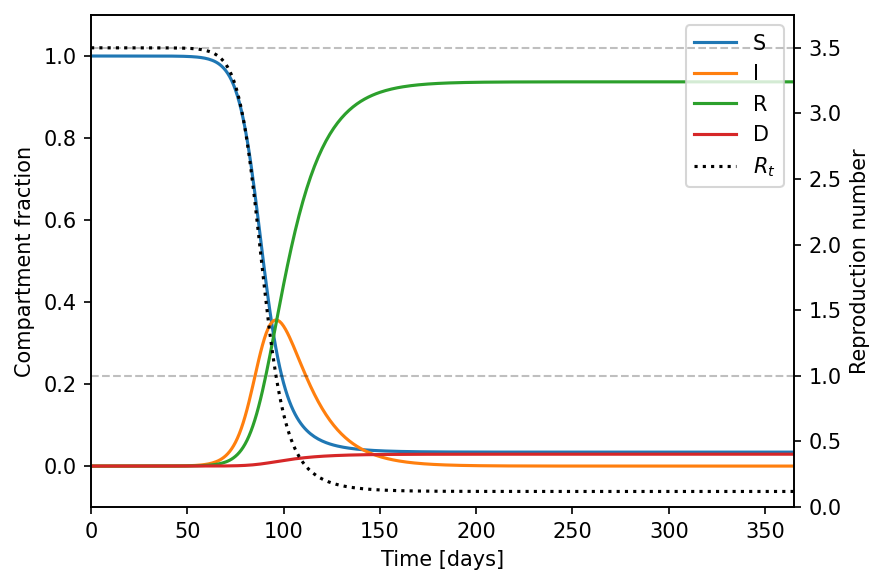

In [36]:
fig, ax = plot_model(data)

In addition to the compartments we plot the reproduction number and horizontal lines for values of reproduction numbers for $1$ and the base reproduction number $R_0$. If the reproduction number is smaller than $1$, the population of the infectious compartment decreases, which can be easily seen in the plot.

We can also print the final state on screen

In [37]:
def print_state(sim):
    for c in sim.comp.__dict__:
        if c.startswith("_"): continue
        print("{:}: {:5.1f} %".format(c, sim.comp.__dict__[c]/sim.pars.N*100.))
    print("Rt: {:5.2f}".format(sim.pars.Rt))

In [38]:
print_state(sim)

S:   3.4 %
I:   0.0 %
R:  93.7 %
D:   2.9 %
Rt:  0.12


At the end of the simulation about 2.9 % of the total population is deceased. This is very close to $\beta$ as it should be, since almost the entire population got infected by the end of the simulation.

At the peak of the infection wave about $100$ days after patient zero about $36\,\%$ of the population is infectious.

In [39]:
print("I_max: {:4.1f} %".format((data.comp.I/data.pars.N).max()*100.))

I_max: 35.6 %


So far our model parameters have been constant with time. But let us assume the following situation.

About $6\,\%$ of the people infected with our fictitious disease need to be treated in an intensive care unit (ICU). That means that at the peak of the wave the ICUs needed a capacity of about $2\,\%$ of the total population. Typical OECD countries have about $10$ ICU beds per $100~000$ population. In our scenario the health care system would be completely overwhelmed by the critial patients potentially increasing the chance of dying because of insufficiant medical care.

We are going to run the simulation again assuming that $6\,\%$ of the infectious require intensive care and further assuming that those patients without a needed ICU bed have a $30$ times higher chance of dying. We can achieve this by increasing our $\beta$ parameter accordingly and calculate an effective $\beta$ parameter.

$\beta = \beta_0 \left[ 1 + \frac{I_\mathrm{w/o}}{I} \left( f-1 \right) \right]$

with $\beta_0$ being the unmodified mortality, $I_\mathrm{w/o}$ the number of infected without an ICU bed that need one, and $f$ a factor that increases the mortality for the latter.

In [40]:
def f_beta_effective(sim):
    
    N = sim.pars.N
    I = sim.comp.I
    
    # Maximum number of ICU beds
    max_icu = 10./100_000. * N
    # Infected requiring ICU bed
    icu_req = 0.06*I
    # Patients without ICU bed
    I_wo = np.maximum(icu_req - max_icu, 0.)
    # Increase in mortality
    f = 30.
    
    return beta*(1+I_wo/I*(f-1))

In [41]:
sim.pars.beta.updater = f_beta_effective

We then have to add the $\beta$ parameters to the update order of the parameters group.

In [42]:
sim.pars.updater = sim.pars.updateorder + ["beta"]

We can now reset the simulation and run it again.

In [43]:
sim.Y = Y0
sim.t = 0.
sim.update()
sim.writer.reset()

In [44]:
sim.run()

Execution time: 0:00:01


In [45]:
data_icu = sim.writer.read.all()

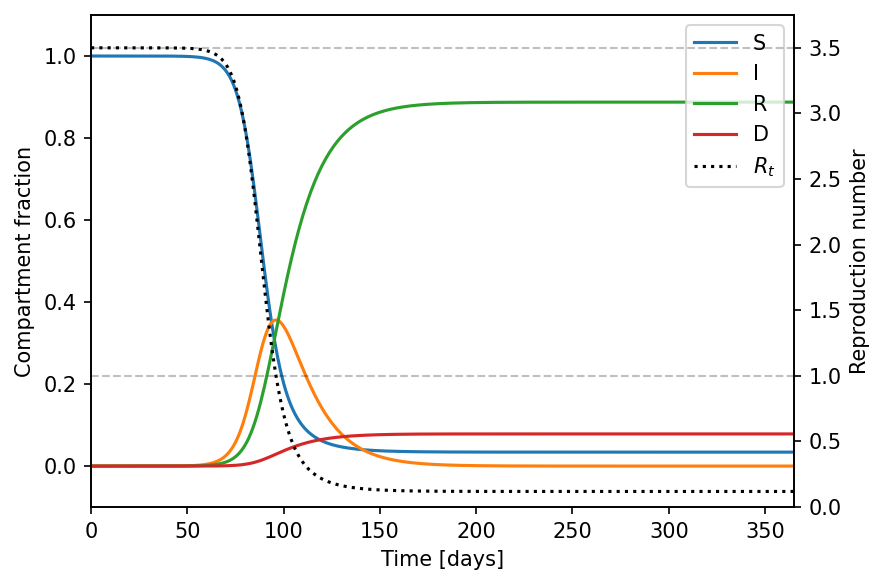

In [46]:
fig, ax = plot_model(data_icu)

In [47]:
print_state(sim)

S:   3.4 %
I:   0.0 %
R:  88.8 %
D:   7.8 %
Rt:  0.12


As can be seen the fraction of deceased is with almost $8\,\%$ more than twice as large as before, which accounts in our case to almost $500~000$ additional casualties.

In [48]:
print("Additional casualties: {:d}".format(int(N*(0.078-0.029))))

Additional casualties: 490000


We can now further assume that some fictitious government implements some kind of contact restrictions as soon as the the ICU occupancy reaches a certain threshold. We can implement this in our model by reducing our $R_1$ parameter – the contact rate – accordingly. We assume that contact restrictions are implemented as soon as the ICU occupancy reaches $90\,\%$, which reduces the contact rate to $50\,\%$ of the initial value, and are lifted again as soon as the ICU occupation drops below $50\,\%$ again. We have therefore two thresholds and we need to know if restrictions are in place when crossing them. We are going to introduce a boolean parameter that stores if contact restrictions are in place or not.

In [49]:
sim.pars.addfield("contact_restrictions", False, description="Contact Restrictions")

In [50]:
def f_R1(sim):
    
    N = sim.pars.N
    I = sim.comp.I
    restr = sim.pars.contact_restrictions
    
    # Maximum number ICU beds
    max_icu = 10./100_000. * N
    # Infected requiring ICU bed
    icu_req = 0.06*I
    # ICU occupation
    icu_occup = icu_req/max_icu
    
    # Lower and upper thresholds
    threshold = (0.5, 0.9)
    
    # Check if the restriction status changes
    # If restrictions are in place and occupancy falls below threshold or
    # if restrictions are not in place and occupancy goes above threshold
    # we flip the contact restriction state
    if (restr and icu_occup<threshold[0]) or (not restr and icu_occup>threshold[1]):
        sim.pars.contact_restrictions = not restr
        
    # If we are restricted return lower contact rate
    if restr:
        return 0.5*R1
    
    # If we are not restriction return unperturbed contact rate
    return R1

In [51]:
sim.pars.R1.updater = f_R1

And we have to add the updater to the list. The updater has to be inserted before the reproduction numbers, since they depend on $R_1$.

In [52]:
sim.pars.updater = ["R1"] + sim.pars.updateorder

We can reset the simulation and run it again.

In [53]:
sim.Y = Y0
sim.t = 0.
sim.update()
sim.writer.reset()

In [54]:
sim.run()

Execution time: 0:00:01


In [55]:
data_restr = sim.writer.read.all()

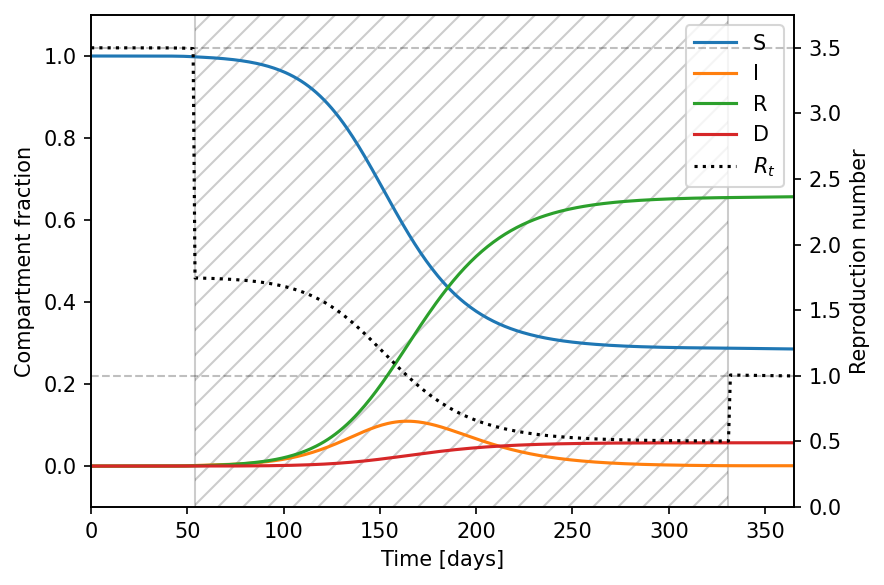

In [56]:
fig, ax = plot_model(data_restr)
i0 = data_restr.pars.contact_restrictions.argmax()
i1 = len(data.t)-data_restr.pars.contact_restrictions[::-1].argmax()-1
ax.axvspan(data_restr.t[i0], data_restr.t[i1], edgecolor="#000000", facecolor="None", hatch="//", alpha=0.2)
plt.show()

In [57]:
print_state(sim)

S:  28.6 %
I:   0.1 %
R:  65.7 %
D:   5.7 %
Rt:  1.00


It is immeadiately visible that the peak of the infectious compartment is at only $11\,\%$ as opposed to the $36\,\%$ without restrictions.

In [58]:
print("I_max: {:4.1f} %".format((data_restr.comp.I/data_restr.pars.N).max()*100.))

I_max: 10.9 %


The contact restrictions – the shaded region – are in place for about $330$ days.

In [59]:
i0 = data_restr.pars.contact_restrictions.argmax()
i1 = len(data_restr.pars.contact_restrictions) - data_restr.pars.contact_restrictions[::-1].argmax() - 1
print("Contact restrictions in place for {:d} days.".format(int(data_restr.t[i1]-data_restr.t[0])))

Contact restrictions in place for 331 days.


At the end of the simulation the fraction of deceased is at about $6\,\%$. Compared to our simulation without restrictions about $210~000$ lives were saved.

In [60]:
print("Lives saved by contact restrictions: {:d}".format(int(N*(0.078-0.057))))

Lives saved by contact restrictions: 209999


After the contact restrictions have been lifted, the reproduction number is stable at one, meaning the spread of the disease is contained.

This model could also be used in the opposite direction. If the structured of the compartmental model is known, the model could be fitted to the data to get the disease parameters.

## SECIR Model

As a second example we want to discuss the SECIR model described by [Khailaie et al. (2020)](https://doi.org/10.1101/2020.04.04.20053637) to model the outbreak of SARS-CoV-2.

The model has eight compartments: $S$usceptible, $E$xposed, $C$arrier, $I$nfected, $R$ecovered, $H$ospitalized, Intensive Care $U$nit, and $D$ead. Compartments $C$ and $I$ are infectious and can infect individuals from compartment $S$. The differential equations governing the system are given by

$\frac{\mathrm{d}}{\mathrm{d}t} S = - R_1 \frac{C + \beta I}{N} S$

$\frac{\mathrm{d}}{\mathrm{d}t} E =  R_1 \frac{C + \beta I}{N} S - R_2 E$

$\frac{\mathrm{d}}{\mathrm{d}t} C =  R_2 E - \left[\left(1 - \alpha\right)R_3 + \alpha R_9 \right] C$

$\frac{\mathrm{d}}{\mathrm{d}t} I = \left(1 - \alpha\right) R_3 C - \left[\left(1-\rho\right) R_4 + \rho R_6 \right] I$

$\frac{\mathrm{d}}{\mathrm{d}t} H = \rho R_6 I  - \left[\left(1-\vartheta\right) R_5 + \vartheta R_7 \right] H$

$\frac{\mathrm{d}}{\mathrm{d}t} U = \vartheta R_7 H - \left[\left(1-\delta\right) R_8 + \delta d \right] U$

$\frac{\mathrm{d}}{\mathrm{d}t} R = \alpha R_9 C + \left(1-\rho\right) R_4 I + \left(1-\vartheta\right) R_5 H + \left(1-\delta\right) R_8 U$

$\frac{\mathrm{d}}{\mathrm{d}t} D = \delta d U$

The system can be graphically represented with [this chart](https://www.medrxiv.org/content/medrxiv/early/2020/04/07/2020.04.04.20053637/F1.large.jpg) from [Khailaie et al. (2020)](https://doi.org/10.1101/2020.04.04.20053637):

$R_1$ is the product of median contact frequency and the transmission probability per contact of a susceptible $\left(S\right)$ and an infectious ($C$ or $I$) person. $\beta < 1$ represents the combined risk attenuation factor of infection from symptomatic patients and patients that have not self-isolated effectively, yet. $\frac{1}{R_2}$ is the median time until an exposed person becomes infectious. $\frac{1}{R_2}+\frac{1}{R_3}$ is the incubation period. $\alpha$ is the fraction of asymptomatic cases.

$\rho$ is the fraction of symptomatic cases that require to be hopitalized. $\frac{1}{R_4}$ is the median time until a symptomatic case recovers. $\frac{1}{R_6}$ is the median time until a symptomatic case gets admitted to the hospital. $\vartheta$ is the fraction of hospitalized patients that require intesive care. And $\delta$ is the fraction of intensive care patients that die. $\frac{1}{R_5}$ and $\frac{1}{R_8}$ are the median times until hospitalized patients and intensive care patients recover. $\frac{1}{R_9}$ is the median time an asymptomatic case remains infectious. And $\frac{1}{d}$ is the median time until intensive care patients die.

In this model the basic reproduction number is given by

$R_0 = R_1 \frac{R_4\left(1-\rho\right) + R_3\beta\left(1-\alpha\right) + R_6\rho}{\left[ R_3\left(1-\alpha\right)+R_9\alpha \right] \left[ R_4\left(1-\rho\right)+R_6\rho \right]}$.

The time-dependent reproduction number is given by 

$R_t = R_0\frac{S}{N}$

These parameters can all vary with time, country, culture, and healthcare system. [Khailaie et al. (2020)](https://doi.org/10.1101/2020.04.04.20053637) used parameters from a fit to early data from Italy.

We are going to use the following values in this example

* $R_1 = 0.587\,\mathrm{days}$
* $\frac{1}{R_2} = 5.2\,\mathrm{days} - \frac{1}{R_3}$ (Incubation period is $5.2\,\mathrm{days}$)
* $R_3 = \frac{1}{4.2\,\mathrm{days}}$
* $R_4 = \frac{1}{14\,\mathrm{days}}$
* $R_5 = \frac{1}{16\,\mathrm{days}}$
* $R_6 = \frac{1}{2.5\,\mathrm{days}}$
* $R_7 = \frac{1}{3.5\,\mathrm{days}}$
* $R_8 = \frac{1}{16\,\mathrm{days}}$
* $\frac{1}{R_9} = \frac{1}{R_3} + \frac{1}{2R_4}$
* $d = \frac{1}{6.92\,\mathrm{days}}$
* $\alpha = 0.01$
* $\beta = 0.05$
* $\delta = 0.15$
* $\vartheta = 0.15$
* $\delta = 0.35$

As before we are going to set up the model.

In [61]:
sim = Frame(description="Khailaie et al. (2020)")

In [62]:
sim.addgroup("pars", description="Model parameters")
sim.pars.addfield("N", 0., description="Population size")
sim.pars.addfield("R0", 0., description="Basic reproduction number")
sim.pars.addfield("Rt", 0., description="Time-dependent reproduction number")
sim.pars.addfield("R1", 0., description="S -> E")
sim.pars.addfield("R2", 0., description="E -> C")
sim.pars.addfield("R3", 0., description="C -> I")
sim.pars.addfield("R4", 0., description="I -> R")
sim.pars.addfield("R5", 0., description="H -> R")
sim.pars.addfield("R6", 0., description="I -> H")
sim.pars.addfield("R7", 0., description="H -> U")
sim.pars.addfield("R8", 0., description="U -> R")
sim.pars.addfield("R9", 0., description="C -> R")
sim.pars.addfield("d", 0., description="U -> D")
sim.pars.addfield("alpha", 0., description="Probability of asymptotic case")
sim.pars.addfield("beta", 0., description="Infection attenuation")
sim.pars.addfield("delta", 0., description="Mortality")
sim.pars.addfield("theta", 0., description="ICU probability")
sim.pars.addfield("rho", 0., description="Hospitalization probability")

In [63]:
sim.pars.N = 10_000_000.
sim.pars.R1 = 0.587
sim.pars.R3 = 1./4.2
sim.pars.R4 = 1./14.
sim.pars.R5 = 1./16.
sim.pars.R6 = 1./2.5
sim.pars.R7 = 1./3.5
sim.pars.R8 = 1./16.
sim.pars.d = 1./6.92
sim.pars.alpha = 0.01
sim.pars.beta = 0.05
sim.pars.delta = 0.15
sim.pars.theta = 0.15
sim.pars.rho = 0.35

We define updater for some of the parameters.

In [64]:
def f_N(sim):
    return sim.Y.sum()

In [65]:
def f_R0(sim):
    R1, R3, R4, R6, R9 = sim.pars.R1, sim.pars.R3, sim.pars.R4, sim.pars.R6, sim.pars.R9
    alpha, beta, rho = sim.pars.alpha, sim.pars.beta, sim.pars.rho
    return R1 * (R4*(1.-rho) + R3*beta*(1.-alpha) + R6*rho) / (R3*(1.-alpha) + R9*alpha) / (R4*(1.-rho) + R6*rho)

In [66]:
def f_Rt(sim):
    return sim.pars.R0*sim.comp.S/sim.pars.N

In [67]:
def f_R2(sim):
    inv = 5.2 - 1./sim.pars.R3
    return 1./inv

In [68]:
def f_R9(sim):
    inv = 1./sim.pars.R3 + 0.5/sim.pars.R4
    return 1./inv

In [69]:
sim.pars.N.updater = f_N
sim.pars.R0.updater = f_R0
sim.pars.Rt.updater = f_Rt
sim.pars.R2.updater = f_R2
sim.pars.R9.updater = f_R9

In [70]:
sim.pars.updater = ["N", "R2", "R9", "R0", "Rt"]

Again we store the comnpartments in the state vecotr $\vec{Y}$.

In [71]:
Y = [sim.pars.N[0]-1, 0., 1., 0., 0., 0., 0., 0.]

In [72]:
sim.addfield("Y", Y, description="State vector")

In [73]:
sim.addgroup("comp", description="Compartments")
sim.comp.addfield("S", 0., description="Susceptible")
sim.comp.addfield("E", 0., description="Exposed")
sim.comp.addfield("C", 0., description="Carrier")
sim.comp.addfield("I", 0., description="Infected")
sim.comp.addfield("H", 0., description="Hospitalized")
sim.comp.addfield("U", 0., description="Intensive Care Unit")
sim.comp.addfield("R", 0., description="Recovered")
sim.comp.addfield("D", 0., description="Dead")

And just copy their values into the compartments group in the systole.

In [74]:
def f_comp_systole(sim):
    sim.comp.S = sim.Y[0]
    sim.comp.E = sim.Y[1]
    sim.comp.C = sim.Y[2]
    sim.comp.I = sim.Y[3]
    sim.comp.H = sim.Y[4]
    sim.comp.U = sim.Y[5]
    sim.comp.R = sim.Y[6]
    sim.comp.D = sim.Y[7]

In [75]:
sim.comp.updater.systole = f_comp_systole

In [76]:
sim.updater = ["comp", "pars"]

The function with the differential equations.

In [77]:
def f_dYdt(sim, x, Y):
    
    S, E, C, I, H, U, R, D = Y
    alpha, beta, delta, theta, rho = sim.pars.alpha, sim.pars.beta, sim.pars.delta, sim.pars.theta, sim.pars.rho
    N, d = sim.pars.N, sim.pars.d
    R1, R2, R3, R4, R5, R6, R7, R8, R9 = sim.pars.R1, sim.pars.R2, sim.pars.R3, sim.pars.R4, sim.pars.R5, sim.pars.R6, sim.pars.R7, sim.pars.R8, sim.pars.R9
    
    dY = np.zeros_like(Y)
    
    dY[0] = -R1*(C+beta*I)*S/N
    dY[1] = -dY[0] - R2*E
    dY[2] = R2*E - ((1.-alpha)*R3 + alpha*R9)*C
    dY[3] = (1.-alpha)*R3*C - ((1.-rho)*R4+rho*R6)*I
    dY[4] = rho*R6*I - ((1.-theta)*R5+theta*R7)*H
    dY[5] = theta*R7*H - ((1.-delta)*R8+delta*d)*U
    dY[6] = alpha*R9*C + (1.-rho)*R4*I + (1.-theta)*R5*H + (1.-delta)*R8*U
    dY[7] = -dY.sum()  # Since the total population size is constant, the last comaprtment is not independent
    
    return dY

In [78]:
sim.Y.differentiator = f_dYdt

And the integration variable. We are going to simulate the model for $180$ days.

In [79]:
sim.addintegrationvariable("t", 0., description="Time [days]")

In [80]:
sim.t.snapshots = np.arange(1., 181., 1.)

We are not going to define a custom function for the time step, that ensures that the compartments are always inbound. Instead we are using an adaptive integration scheme. Therefore the time step updater needs to return the suggested time step.

In [81]:
def f_dt(sim):
    return sim.t.suggested

In [82]:
sim.t.updater = f_dt

And we initialize it with a value of $1$ day.

In [83]:
sim.t.suggest(1.)

Then we define the integrator with a single integration instruction.

In [84]:
sim.integrator = Integrator(sim.t)

In [85]:
sim.integrator.instructions = [
    Instruction(schemes.expl_5_cash_karp_adptv, sim.Y)
]

We are using the namespace writer and turn off the verbosity.

In [86]:
sim.writer = writers.namespacewriter()
sim.writer.verbosity = 0

The model is now complete.

In [87]:
sim.toc

Frame (Khailaie et al. (2020))
    - comp: Group (Compartments)
        - C: Field (Carrier)
        - D: Field (Dead)
        - E: Field (Exposed)
        - H: Field (Hospitalized)
        - I: Field (Infected)
        - R: Field (Recovered)
        - S: Field (Susceptible)
        - U: Field (Intensive Care Unit)
    - pars: Group (Model parameters)
        - alpha: Field (Probability of asymptotic case)
        - beta: Field (Infection attenuation)
        - d: Field (U -> D)
        - delta: Field (Mortality)
        - N: Field (Population size)
        - R0: Field (Basic reproduction number)
        - R1: Field (S -> E)
        - R2: Field (E -> C)
        - R3: Field (C -> I)
        - R4: Field (I -> R)
        - R5: Field (H -> R)
        - R6: Field (I -> H)
        - R7: Field (H -> U)
        - R8: Field (U -> R)
        - R9: Field (C -> R)
        - rho: Field (Hospitalization probability)
        - Rt: Field (Time-dependent reproduction number)
        - theta: Field (ICU

Before we can run the simulation we have to update the simulation frame.

In [88]:
sim.update()

In [89]:
sim.run()

Execution time: 0:00:01


After the simulation we can plot the results.

In [90]:
data = sim.writer.read.all()

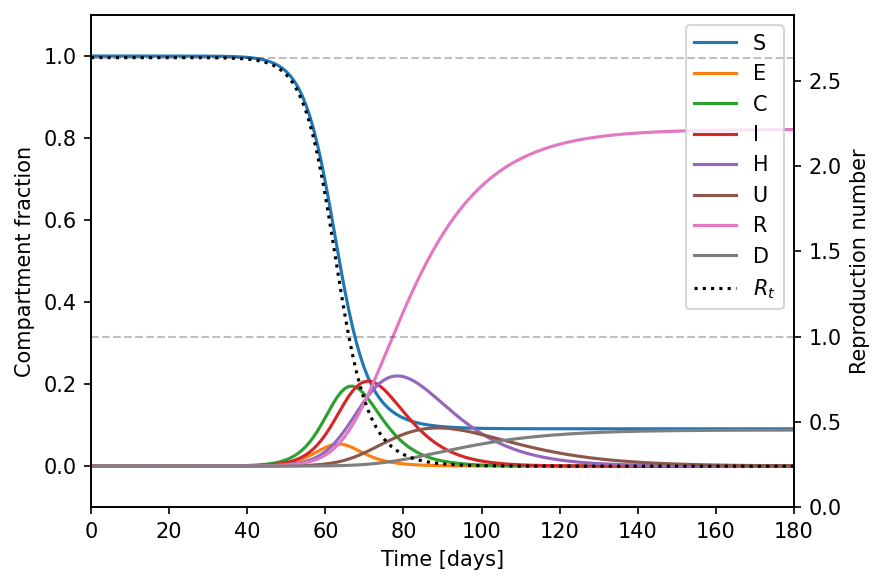

In [91]:
fig, ax = plot_model(data)

In [92]:
print_state(sim)

S:   9.1 %
E:   0.0 %
C:   0.0 %
I:   0.0 %
H:   0.0 %
U:   0.1 %
R:  82.1 %
D:   8.8 %
Rt:  0.24


At the end of this simulation about $9\,\%$ of the population died.

In [93]:
print("I_max: {:4.1f} %".format((data.comp.U/data.pars.N).max()*100.))

I_max:  9.3 %


At the peak of the infection wave. At the peak of the wave about $9\,\%$ of the population would require intensive care overwhelming any healthcare system in the world.

Please note that there are more complex models and updated parameters available by now.